In [3]:
import os
import sys
import numpy as np
import anndata as ad
import scanpy as sc
import random
import pandas as pd
import scipy.sparse as sp_sparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
from scipy import stats
import umap
from collections import defaultdict
import matplotlib.lines as mlines
from sklearn.cluster import KMeans


In [4]:
path_data = ""

# load data
```adata``` is the preprocessed anndata of predicted mutations  
```adata.mean``` represents the mean expression of each perturbation, used to indicate the effect of each mutation.

In [16]:
adata = ad.read_h5ad(path_data + "mutation_pred_markerhvg_results_cluster_info_final.h5ad")
adata.mean = ad.read_h5ad(path_data + "mutation_pred_hvgmarker_mean.h5ad")

# Visualize marker representatives.

In [17]:
# HSC markers
adata.obs["CD34"] =adata.X[:,212]
# erythroid markers
adata.obs["HBB"] =adata.X[:,1459]
# Meg markers
adata.obs["PF4"] =adata.X[:,641]
# bas markers
adata.obs["CLC"] =adata.X[:,2298]
# mon markers
adata.obs["CD14"] =adata.X[:,817]
adata.obs["MPO"] =adata.X[:,2109]
# bas markers
adata.obs["CEBPA"] =adata.X[:,2282]
# Neu/Mon both expresses
adata.obs["LYZ"] =adata.X[:,1674]
# Terminal erythroid mean expression
adata.obs["Terminal Ery Genes"] =adata.obs["ery_expr"]

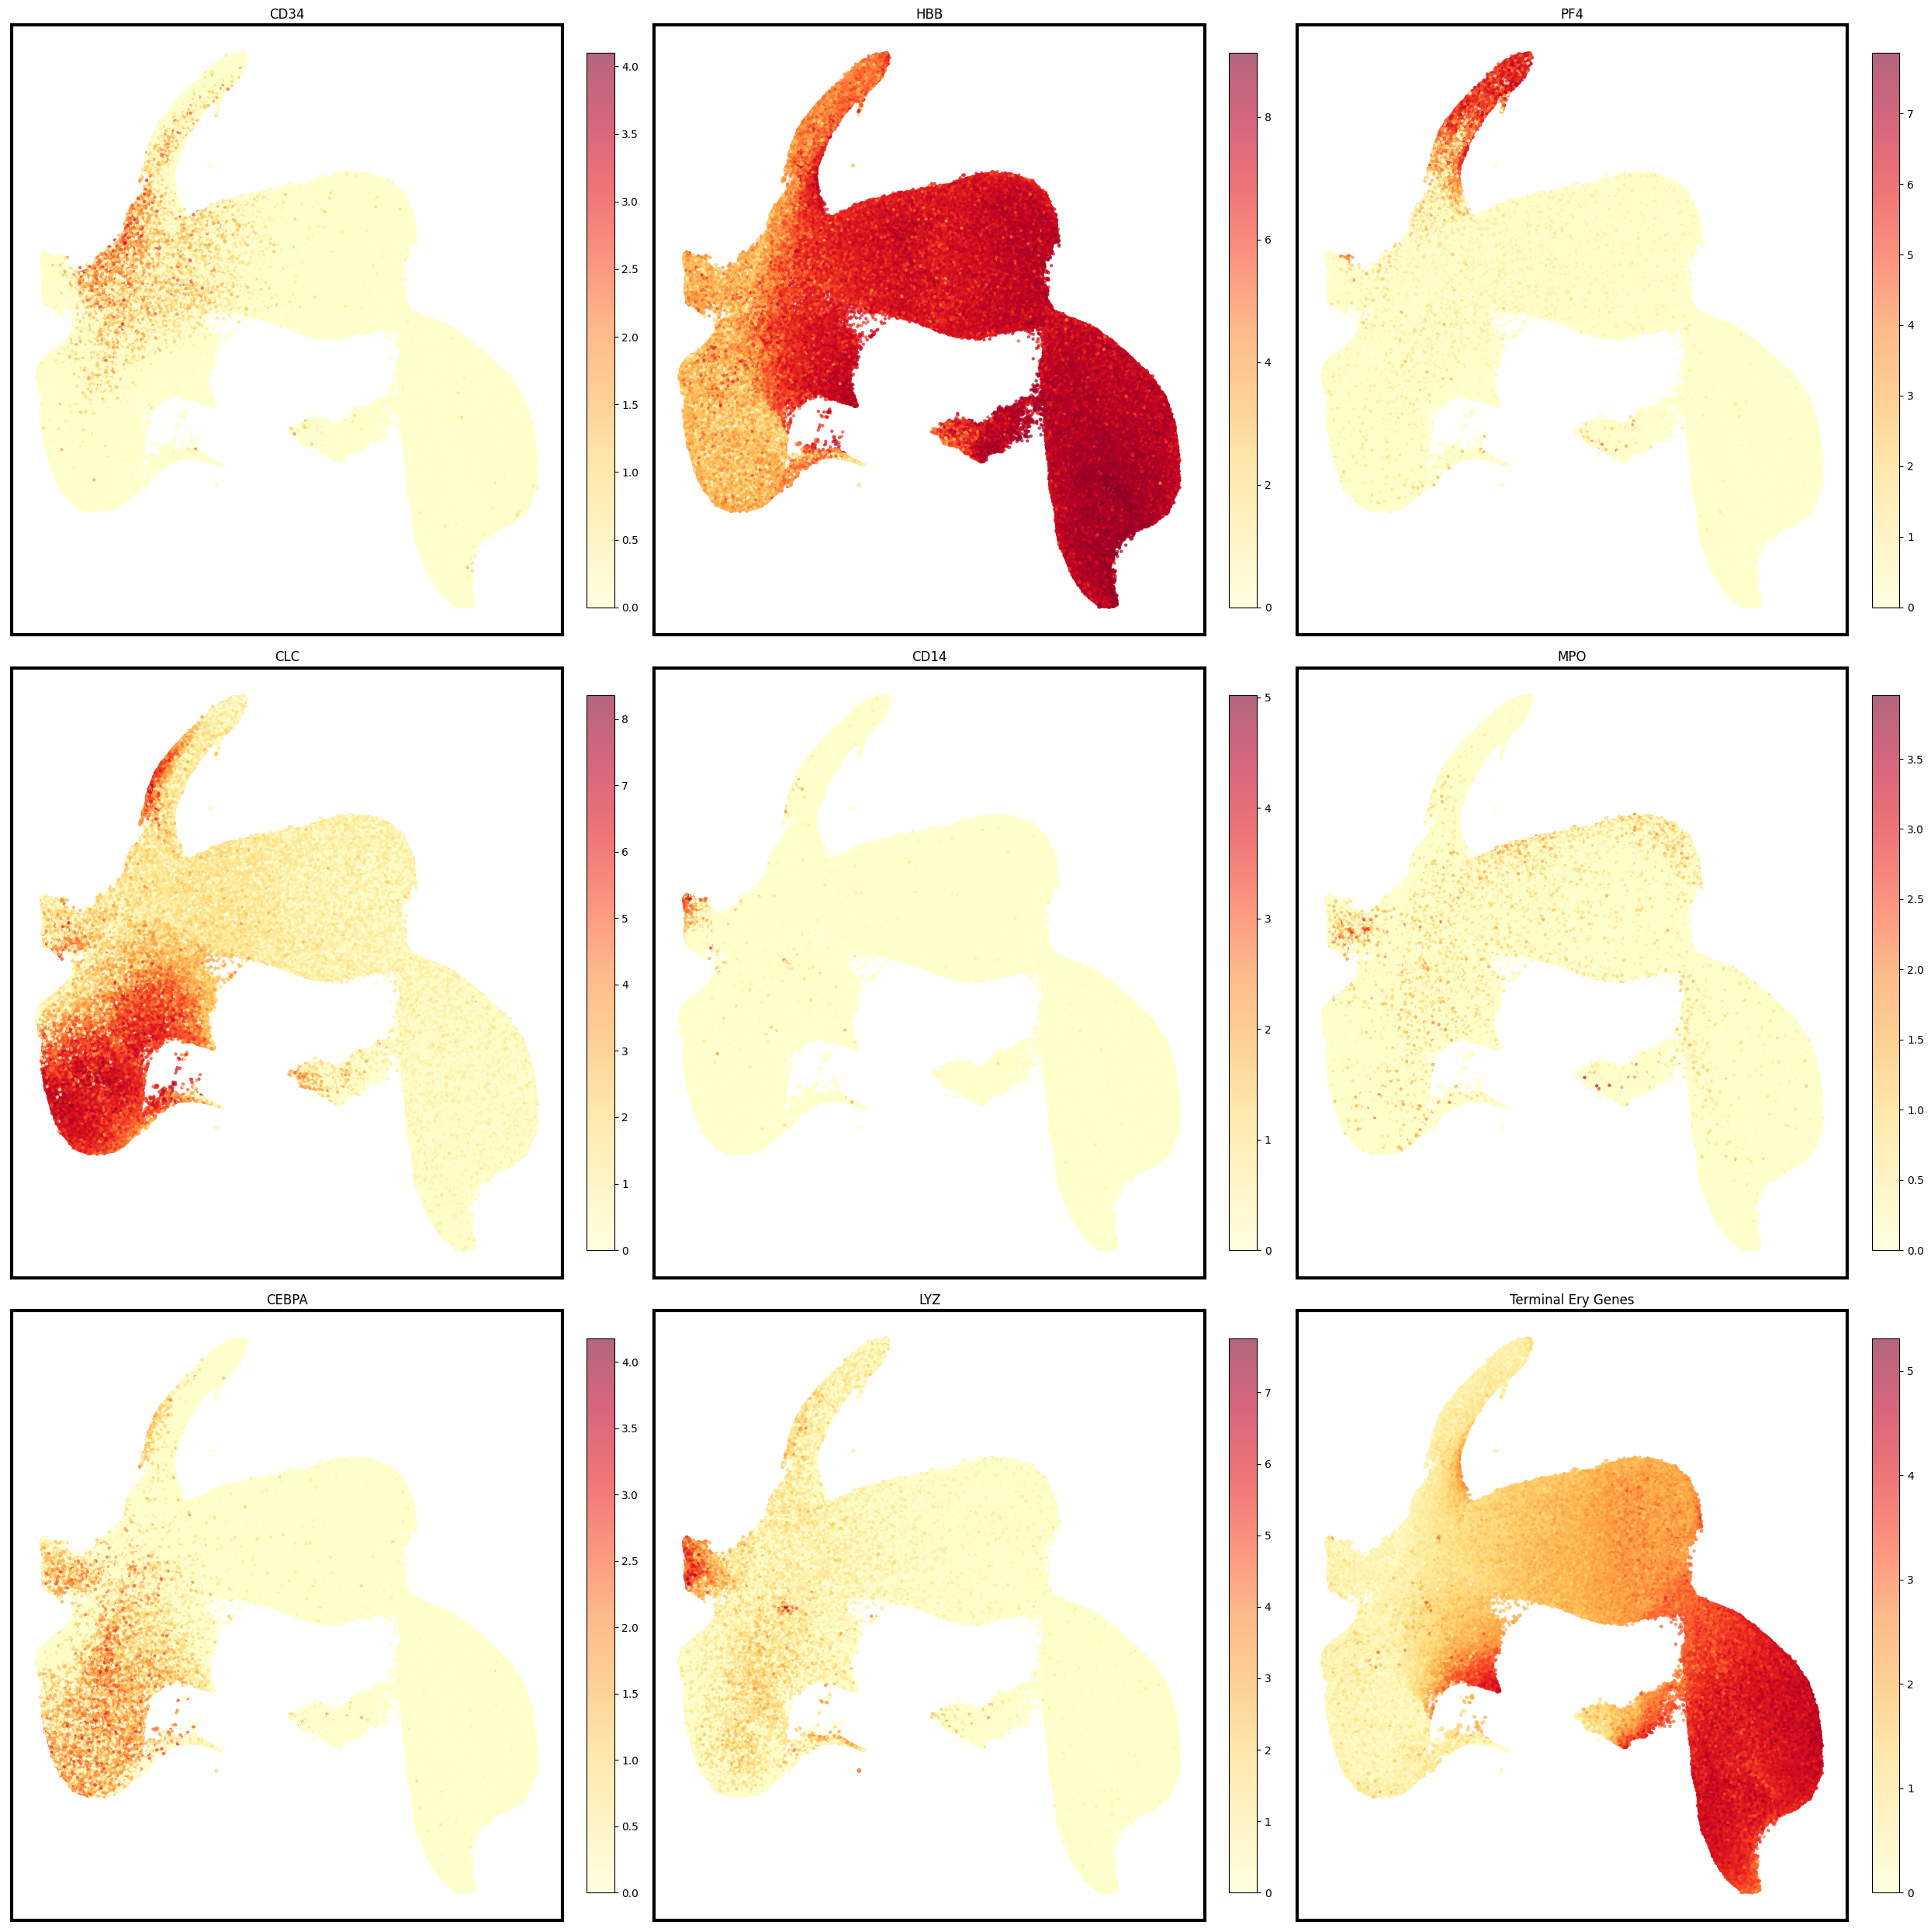

In [18]:
genes = ["CD34", "HBB", "PF4", "CLC", "CD14", "MPO", "CEBPA", "LYZ", "Terminal Ery Genes"]

fig, axs = plt.subplots(3, 3, figsize=(25, 25))

# Plot each gene expression on a separate UMAP plot
for i, gene in enumerate(genes):
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(adata.obsm["Umap_train"][:,0], adata.obsm["Umap_train"][:,1], 
                    c=adata.obs[gene], cmap='YlOrRd', s=5, alpha=0.6, marker='o')
    ax.set_title(gene)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(3)
    fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("Marker_example.png", dpi = 600)
plt.show()

# Visualiztion of cell types and projected mean expression of perturbations
The data was downsampled to better show the distinct clusters. The downsampled data retains the original data's structure

In [17]:
downsampled_adata = ad.read_h5ad(path_data + "GATA1_downsmapled_markerhvg_final.h5ad")

<Figure size 1000x1000 with 0 Axes>

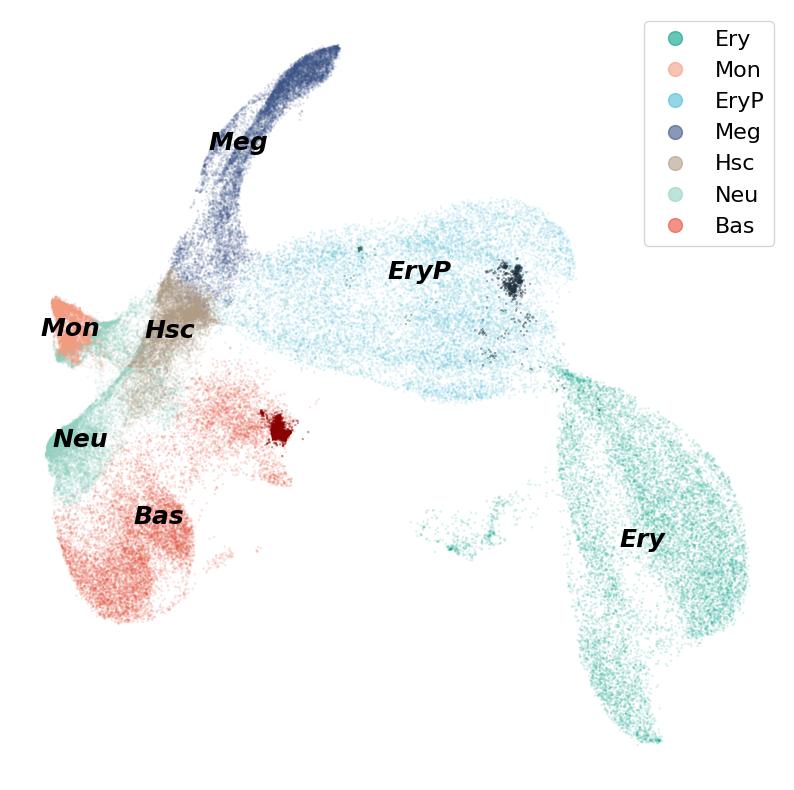

In [29]:
mean_pred_umap = downsampled_adata.uns["Umap_transformed_mean"]
df = pd.DataFrame(mean_pred_umap)
k = 3  


kmeans = KMeans(n_clusters=k, random_state=0)
df['kmeans_clusters'] = kmeans.fit_predict(mean_pred_umap)
unique_lineages = list( downsampled_adata.obs["lineage_manual_final_plot"].unique())
text_poi_dict = downsampled_adata.uns["Cluster_text_poi"]
color_mapping ={'Bas': '#E64B35FF',
 'EryP': '#4DBBD5FF',
 'Ery': '#00A087FF',
 'Meg': '#3C5488FF',
 'Mon': '#F39B7FFF',
 'Hsc': '#8491B4FF',
 'Neu': '#91D1C2FF'}


color_mapping["Hsc"] = "#B09C85FF"
unique_cluster = df["kmeans_clusters"].unique()
color_mapping_mapping_mean_cluster = {0:"darkred",1:"#223240", 2:"#367356"}
plt.figure(figsize=[10, 10])

plt.figure(figsize=[10, 10])

for lineage in unique_lineages:
    plot_data = downsampled_adata[downsampled_adata.obs["lineage_manual_final_plot"] == lineage]

    plt.scatter(plot_data.obsm['Umap_train'][:, 0], plot_data.obsm['Umap_train'][:, 1], 
                s=3, color=color_mapping[lineage], edgecolors="None", linewidth=0, alpha=0.15)


    centroid = text_poi_dict[lineage]
    plt.text(centroid[0], centroid[1], lineage, fontsize=18, ha='center', va='center', 
             style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


for cluster in unique_cluster:
    plot_data = df[df["kmeans_clusters"] == cluster]
    plt.scatter(plot_data[0], plot_data[1], 
                s=3, cmap='tab10', edgecolors="None", linewidth=0, alpha=0.5 ,marker='X', 
                color = color_mapping_mapping_mean_cluster[cluster]
               )



legend_handles = [mlines.Line2D([], [], color=color_mapping[lineage], marker='o', linestyle='None', 
                                markersize=10, label=lineage, alpha=0.6)  # set your desired alpha for the legend markers
                  for lineage in unique_lineages]


plt.legend(handles=legend_handles, fontsize=16, markerscale=1)



ax = plt.gca()
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('3')

plt.axis('off')
plt.show()

# Load the cell density for each perturbation cluster

To calculate the density

```
from sklearn.neighbors import KernelDensity

def normalize_density(density_values):
    min_density = np.min(density_values)
    max_density = np.max(density_values)
    normalized_density = (density_values - min_density) / (max_density - min_density)
    return normalized_density
adata_tmp = adata[adata.obs["mutation_name"].isin(cluster_list)]
kde_large = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde_large.fit(adata_tmp.obsm["Umap_train"])
density = normalize_density( np.exp(kde_large.score_samples(adata.obsm["Umap_train"])))
```
Here, ```cluster_list``` represents the mutations within a specific cluster. This process can be very time-consuming due to the large number of cells in each mutation cluster.

In [23]:
cluster_inter_density = np.load(path_data + "cluster0_density.npy")
cluster_enrich_density = np.load(path_data + "cluster1_density.npy")
cluster_del_density = np.load(path_data + "cluster2_density.npy")

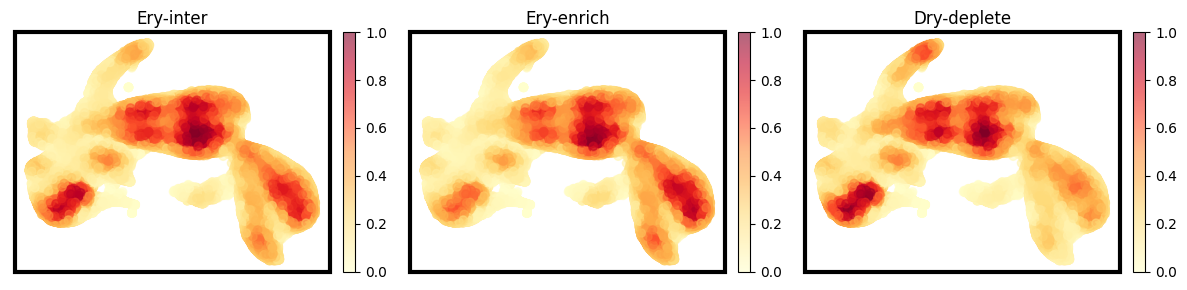

In [24]:
densities = [cluster_inter_density, cluster_enrich_density, cluster_del_density]
titles = ["Ery-inter", "Ery-enrich", "Dry-deplete"]
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for i, (density, title) in enumerate(zip(densities, titles)):
    ax = axs[i]
    sc = ax.scatter(adata.obsm["Umap_train"][:,0], adata.obsm["Umap_train"][:,1], c=density, cmap='YlOrRd', s=35, alpha=0.6, marker='o')
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(3)
    fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()

# Large effect mutations ranked by mean logfc

In [32]:
df_poi = pd.read_csv("/nfs/turbo/umms-welchjd/wzqian/shared/jorge/max_effect_per_residue_markerhvg_meaneffect.csv")

In [41]:
df_poi_sub = df_poi[df_poi["if_in_structure"] == "yes"]
#print(sum(df_poi_sub.iloc[0:10]["contact"] != "Other residue"))
df_poi_sub = df_poi_sub.sort_values(by = "mean_large_logfc", ascending= False )
df_poi_sub.iloc[0:10,2]

64     W215R
180    T212C
93     K233C
148    I302L
94     A273C
338    R270E
80     G236D
374    N306V
277    E203D
397    R305Y
Name: mutation_name, dtype: object

# Distributions of three types of mutations 

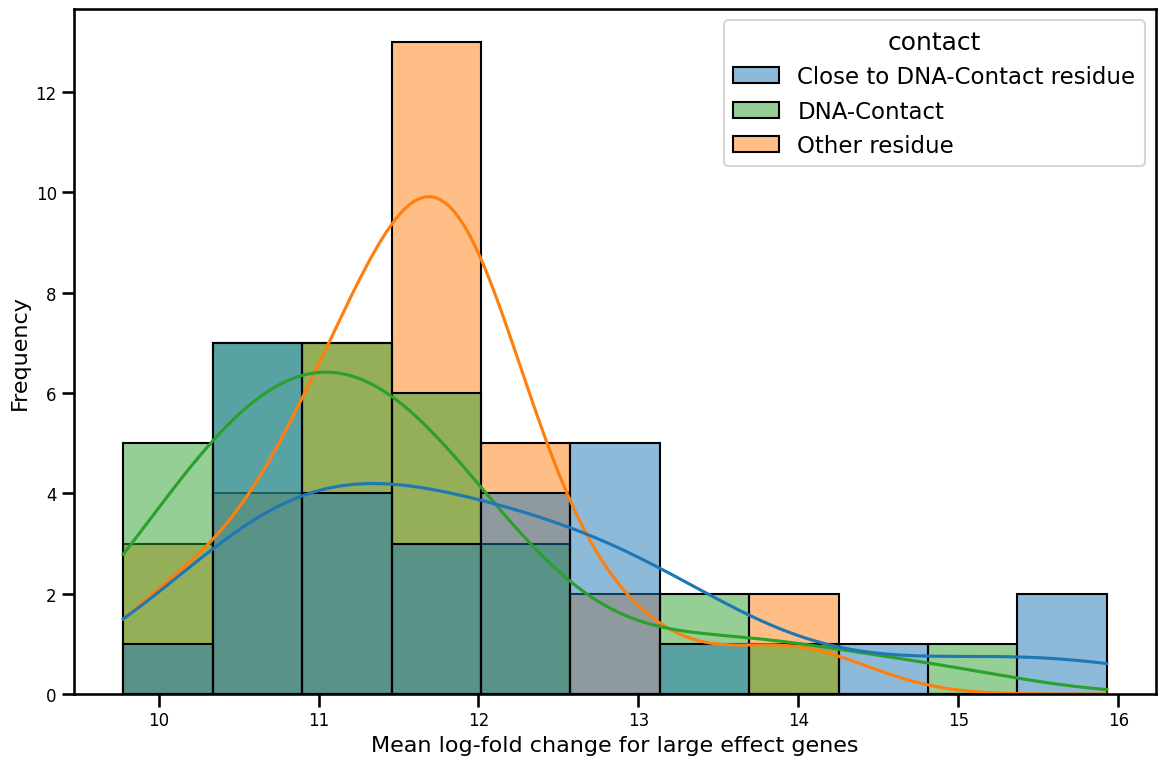

In [35]:
palette = {'Close to DNA-Contact residue': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'Other residue': (1.0, 0.4980392156862745, 0.054901960784313725),
 'DNA-Contact': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}

plt.figure(figsize=(12, 8))
sns.set_context("talk")  # Adjust text size for larger fonts
sns.histplot(data=df_poi_sub, x="mean_large_logfc", hue="contact", palette=palette, kde=True)

plt.xlabel('Mean log-fold change for large effect genes', fontsize=16)

plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
